In [1]:
from old_model import *
from dataloader import *
from cevae_dataloader import *
from loss import *
import numpy as np
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=1):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

In [3]:
set_seed(1)

In [4]:
path = './all_normal/'
ab_path = './All_abnormal/'
patchsize = (64,64)
margin = (80,80)
batch_size = 1
num_workers = 1

In [5]:
model = torch.load('VAE_models/VAE_1024_0.0001_596.pt',map_location=device)

In [6]:
testNormal = cevae(path,patchsize,margin)
testAb = cevae(ab_path,patchsize,margin)
testNormalLoader = DataLoader(testNormal,batch_size=batch_size,num_workers=num_workers)
testAbnormalLoader = DataLoader(testAb,batch_size=batch_size,num_workers=num_workers)

In [7]:
model.eval()
test_loss = []
kl_loss = []
rec_loss = []
for idx, data in enumerate(testNormalLoader):
    data = data.to(device)
    recon, mu,logstd = model(data)
    combi_loss,rec,kl = kl_loss_fn(recon,data,mu,logstd)
    combi_loss,rec,kl = combi_loss.detach().cpu().numpy(),rec.detach().cpu().numpy(),kl.detach().cpu().numpy()
    test_loss.append(combi_loss)
    kl_loss.append(kl)
    rec_loss.append(rec)

In [8]:
model.eval()
test_loss_ab = []
kl_loss_ab = []
rec_loss_ab = []
for idx,abdata in enumerate(testAbnormalLoader):
    abdata = abdata.to(device)
    recon_ab, mu_ab, logstd_ab = model(abdata)
    combi_loss_ab, rec_ab,kl_ab = kl_loss_fn(recon_ab,abdata,mu_ab,logstd_ab)
    combi_loss_ab, rec_ab,kl_ab = combi_loss_ab.detach().cpu().numpy(),rec_ab.detach().cpu().numpy(),kl_ab.detach().cpu().numpy()
    test_loss_ab.append(combi_loss_ab)
    kl_loss_ab.append(kl_ab)
    rec_loss_ab.append(rec_ab)

In [9]:
import sklearn.metrics as sk
def auroc_metric(_pos,_neg):
#     def get_auroc(_pos, _neg):
    pos = np.array(_pos[:]).reshape((-1, 1))
    neg = np.array(_neg[:]).reshape((-1, 1))
    examples = np.squeeze(np.vstack((pos, neg)))
    labels = np.zeros(len(examples), dtype=np.int32)
    labels[:len(pos)] += 1

    auroc = sk.roc_auc_score(labels, examples)
    aupr = sk.precision_recall_curve(labels,examples)
    auroc_curve = sk.roc_curve(labels,examples)
    return auroc,aupr,auroc_curve

In [10]:
aur_combi,combi_pr,combi_aur = auroc_metric(test_loss_ab,test_loss)
aur_kl,kl_pr,kl_aur = auroc_metric(kl_loss_ab,kl_loss)
aur_rec,rec_pr,rec_aur = auroc_metric(rec_loss_ab,rec_loss)

In [11]:
aur_combi,aur_kl,aur_rec

(0.732768177761537, 0.43811957583466266, 0.8037937007652686)

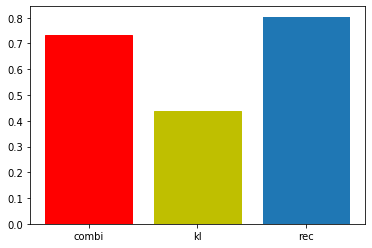

In [12]:
x = ['combi','kl','rec']
height = [aur_combi,aur_kl,aur_rec]
vae = plt.bar(x,height)
vae[0].set_color('r')
vae[1].set_color('y')

In [13]:
prec_combi,recall_combi,threshold_combi = combi_pr
fpr,tpr,thresholds = combi_aur

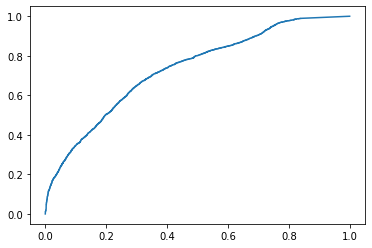

In [14]:
# plt.plot(prec_combi,recall_combi)
plt.plot(fpr,tpr)

In [15]:
ctestNormal = cevae_ct(path,patchsize,margin)
ctestAb = cevae_ct(ab_path,patchsize,margin)
ctestNormalLoader = DataLoader(testNormal,batch_size=batch_size,num_workers=num_workers)
ctestAbnormalLoader = DataLoader(testAb,batch_size=batch_size,num_workers=num_workers)

In [16]:
cevae_model = torch.load('models/ceVAE_512_0.0001_500.pt',map_location=device)

In [17]:
cevae_model.eval()
test_loss_ce = []
kl_loss_ce = []
rec_loss_ce = []
for idx, data in enumerate(ctestNormalLoader):
    inpt, inpt_noisy = data
        
    inpt = inpt.to(device)
    inpt_noisy = inpt_noisy.to(device)
    x_rec_vae, z_dist,std = cevae_model(inpt)
    x_rec_ce,_,_ = cevae_model(inpt_noisy)

        # kl_loss,kl_div,joint_nll = kl_loss_fn(x_rec_vae,inpt,z_dist,std)
    c,kl,rec = kl_loss_fn(x_rec_vae,inpt,z_dist,std)
        # print(kl_div,joint_nll)
    rec_loss_vae = rec_loss_fn(x_rec_vae, inpt)
        # pdb.set_trace()
    loss_vae = rec_loss_vae  + c * beta  

    rec_loss_ce = rec_loss_fn(x_rec_ce, inpt)

    loss_ce = rec_loss_ce

    loss = (1. - lamda) * loss_vae + lamda * loss_ce
#     data = data.to(device)
#     recon, mu,logstd = cevae_model(data)
#     combi_loss,rec,kl = kl_loss_fn(recon,data,mu,logstd)
#     combi_loss,rec,kl = combi_loss.detach().cpu().numpy(),rec.detach().cpu().numpy(),kl.detach().cpu().numpy()
    test_loss_ce.append(loss)
#     kl_loss_ce.append(kl)
#     rec_loss_ce.append(rec)

ValueError: not enough values to unpack (expected 2, got 1)

In [32]:
cevae_model.eval()
test_loss_cab = []
kl_loss_cab = []
rec_loss_cab = []
for idx,abdata in enumerate(ctestAbnormalLoader):
    inpt, inpt_noisy = abdata

    inpt = inpt.to(device)
    inpt_noisy = inpt_noisy.to(device)
    optimizer.zero_grad()
    x_rec_vae, z_dist,std = cevae_model(inpt)
    x_rec_ce,_,_ = cevae_model(inpt_noisy)

    # kl_loss,kl_div,joint_nll = kl_loss_fn(x_rec_vae,inpt,z_dist,std)
    ckl_loss, ckl,crec = kl_loss_fn(x_rec_vae,inpt,z_dist,std)
    # print(kl_div,joint_nll)
    rec_loss_vae = rec_loss_fn(x_rec_vae, inpt)
    # pdb.set_trace()
    closs_vae = rec_loss_vae  + ckl_loss * beta  

    crec_loss_ce = rec_loss_fn(x_rec_ce, inpt)

    loss_ce = rec_loss_ce

    closs = (1. - lamda) * closs_vae + lamda * loss_ce
    
#     inpt, inpt_noisy
#     abdata = abdata.to(device)
#     recon_ab, mu_ab, logstd_ab = cevae_model(abdata)
#     combi_loss_ab, rec_ab,kl_ab = kl_loss_fn(recon_ab,abdata,mu_ab,logstd_ab)
#     combi_loss_ab, rec_ab,kl_ab = combi_loss_ab.detach().cpu().numpy(),rec_ab.detach().cpu().numpy(),kl_ab.detach().cpu().numpy()
    test_loss_cab.append(closs)
#     kl_loss_cab.append(kl_ab)
#     rec_loss_cab.append(rec_ab)

In [33]:
caur_combi,ccombi_pr,ccombi_aur = auroc_metric(test_loss_cab,test_loss_ce)
caur_kl,ckl_pr,ckl_aur = auroc_metric(kl_loss_cab,kl_loss_ce)
caur_rec,crec_pr,crec_aur = auroc_metric(rec_loss_cab,rec_loss_ce)

In [36]:
height_ce = [caur_combi,caur_kl,caur_rec]
caur_combi,caur_kl,caur_rec

(0.7461071797502513, 0.4703081980000422, 0.8062293486433877)

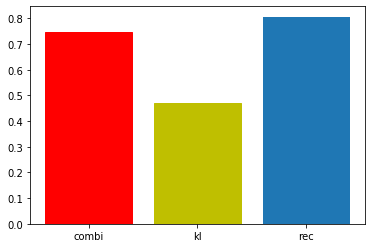

In [37]:
cevae = plt.bar(x,height_ce)
cevae[0].set_color('r')
cevae[1].set_color('y')